In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange
import gymnasium as gym
import gym as gym_old
from tqdm.auto import tqdm
import procgen
import cv2
import os
# from ppo import *

from IPython.display import clear_output

/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
import miner
import models
import testing_ppo_rnd

In [5]:
def plot_rewards(envs):
    minlen = min([len(e.past_returns) for e in envs.envs])
    past_returns = np.array([e.past_returns[-minlen:] for e in envs.envs])
    mean = past_returns.mean(axis=0)
    min_ = past_returns.min(axis=0)
    max_ = past_returns.max(axis=0)
    stderr = past_returns.std(axis=0)/np.sqrt(past_returns.shape[0])
    x = np.arange(len(mean))
    plt.plot(x, mean, c='b')
    plt.plot(x, min_, c='r')
    plt.plot(x, max_, c='g')
    plt.fill_between(x, mean-stderr, mean+stderr, color=[0, 0, 1, .2])

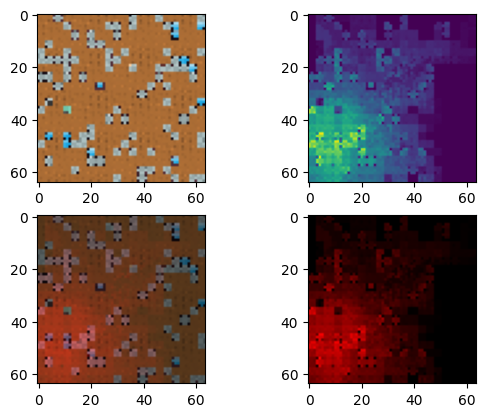

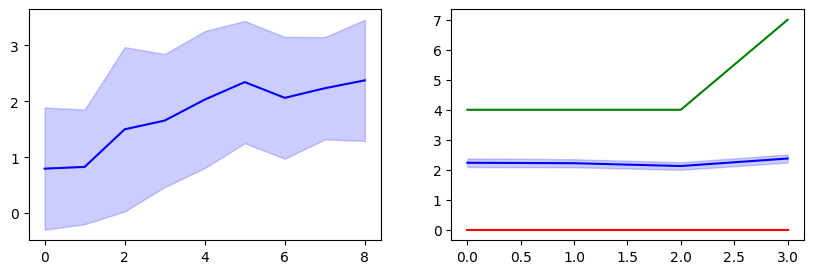

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 9/12 [01:35<00:31, 10.62s/it]


KeyboardInterrupt: 

In [143]:
env = miner.make_env(64)

r = []
r_means, r_stds = [], []
def callback(update, rewards, **kwargs):
    if update%1==0:
        e = env.envs[0]
        r_means.append(np.mean([e.past_returns[-1] for e in env.envs]))
        r_stds.append(np.std([e.past_returns[-1] for e in env.envs]))
        r.append(rewards.mean().item())
        clear_output(wait=True)
        o = kwargs['b_obs'][:, -1].cpu().numpy()
        o = o.std(axis=0).mean(axis=-1)
        heatmap = (o/o.max()*255).astype(np.uint8)
        
        plt.subplot(221)
        plt.imshow(e.first_obs)
        plt.subplot(222)
        plt.imshow(o)
        
        first_obs = e.first_obs.copy()
        red = np.zeros_like(first_obs)
        red[:, :, 0] = heatmap
        
        first_obs = (first_obs*.5+red*.5).astype(np.uint8)
        
        plt.subplot(223)
        plt.imshow(first_obs)
        plt.subplot(224)
        plt.imshow(red)
        plt.show()
        
        plt.figure(figsize=(10, 3))
        plt.subplot(121)
        # plt.plot(r)
        plt.plot(r_means, color='b')
        mean, std = np.array(r_means), np.array(r_stds)
        plt.fill_between(range(len(mean)), mean-std, mean+std, color=[0,0, 1.,.2])
        plt.subplot(122)
        plot_rewards(env)
        plt.show()
    
agent = models.Agent(env)
rnd = models.RNDModel(env, (64, 64, 3))
n_params = np.sum([p.numel() for p in agent.parameters()])
print(f'Agent # parameters: {n_params:012d}')
n_params = np.sum([p.numel() for p in rnd.parameters()])
print(f'RND   # parameters: {n_params:012d}')

parser = testing_ppo_rnd.parse_args()
args = parser.parse_args('--total-timesteps 200000 --ext-coef 1.0 --int-coef 0.0 --num-minibatches 50 --ent-coef 0.0'.split())
args.total_timesteps
testing_ppo_rnd.run(agent, rnd, env, args, callback_fn=callback)

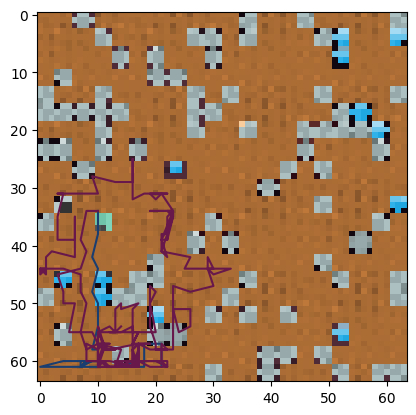

In [109]:
def calc_traj(traj_obs):
    a = traj_obs
    c = np.array([111, 196, 169])
    
    y, x = [], []
    a = np.abs(a-c).mean(axis=-1)
    for ai in a:
        yi, xi = np.unravel_index(ai.argmin(), ai.shape)
        y.append(yi)
        x.append(xi)
    y, x = np.array(y), np.array(x)
    x += np.random.randint(-1, 1, x.shape)
    y += np.random.randint(-1, 1, y.shape)
    c = np.random.rand(3)*.5

    plt.plot(x, y, c=c)

plt.imshow(env.envs[1].first_obs)

for e in env.envs[:2]:
    calc_traj(e.past_traj_obs)

In [144]:
first_obs = e.first_obs.copy()
calc_traj_cov = lambda o:(o.std(axis=0).mean(axis=-1)>0).sum()/first_obs.mean(axis=-1).size
traj_cov = np.array([calc_traj_cov(e.past_traj_obs) for e in env.envs])
full_cov = calc_traj_cov(np.concatenate([e.past_traj_obs for e in env.envs]))

In [145]:
traj_cov.mean(), full_cov

(0.07220458984375, 0.68701171875)

In [89]:
e = miner.make_env(1)
e.reset()
for i in tqdm(range(2000)):
    e.step([np.random.choice([3,4])])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3562.52it/s]


In [90]:
o = e.envs[0].past_traj_obs
o.shape

(1001, 64, 64, 3)

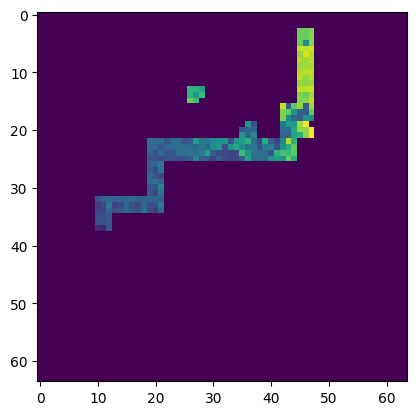

In [91]:
a = np.array([ei.past_traj_obs.std(axis=0).mean(axis=-1) for ei in e.envs])[[0]].max(axis=0)
plt.imshow(a)

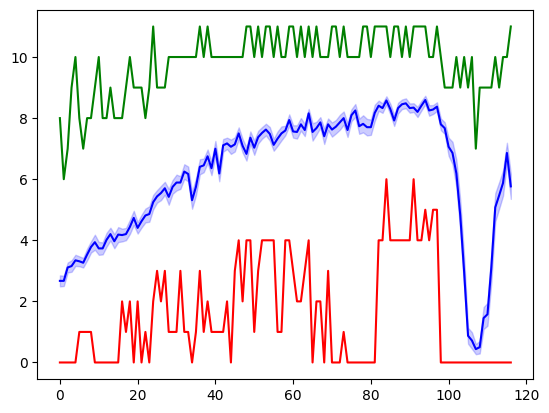

In [168]:
plot_rewards(env)

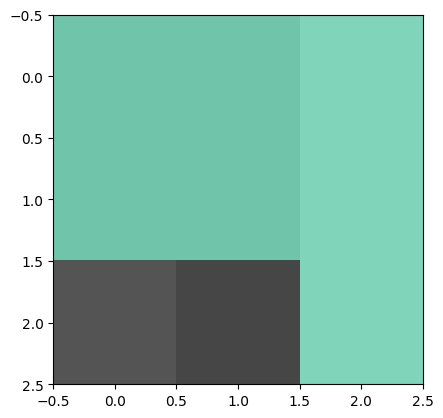

In [63]:
plt.imshow(env.envs[0].first_obs[35: 38, 10:13])

In [66]:
env.envs[0].first_obs[35: 38, 10:13][1, 1]

array([111, 196, 169], dtype=uint8)

In [169]:
np.argmax([np.max(e.past_returns) for e in env.envs])

3

In [170]:
np.argmax(env.envs[3].past_returns)

60

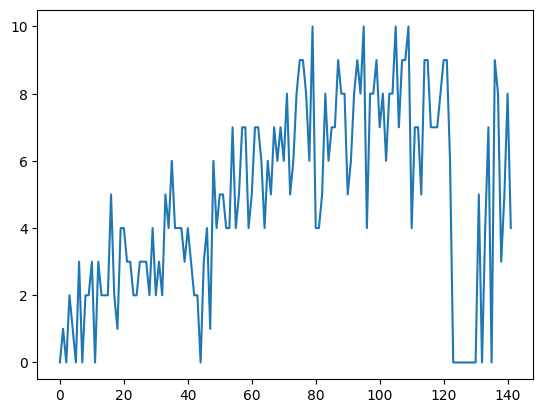

In [176]:
plt.plot(env.envs[0].past_returns)

In [177]:
env.envs[0].past_returns[125]

0.0

In [180]:
env.envs[0].past_returns[-1], env.envs[0].past_lengths[-1]

(4.0, 134)

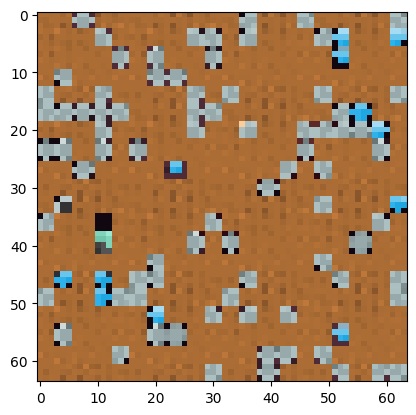

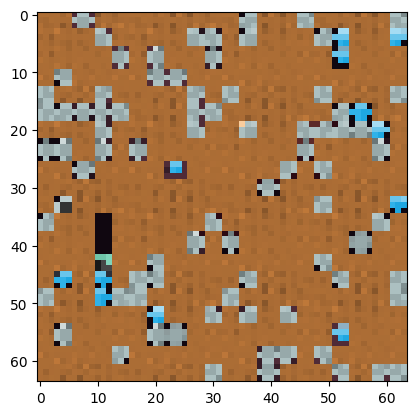

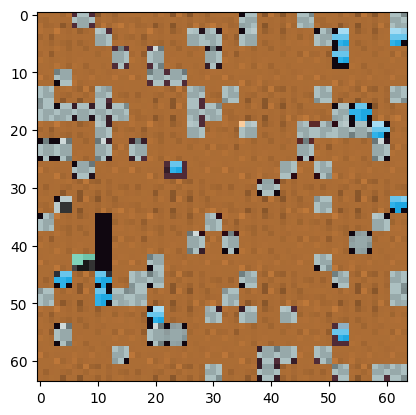

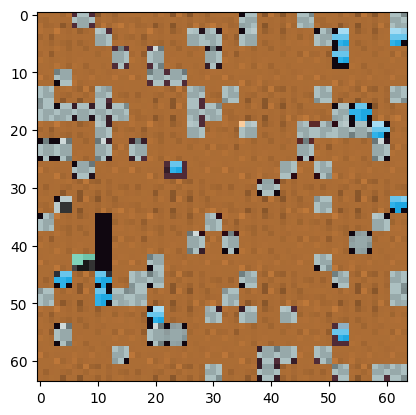

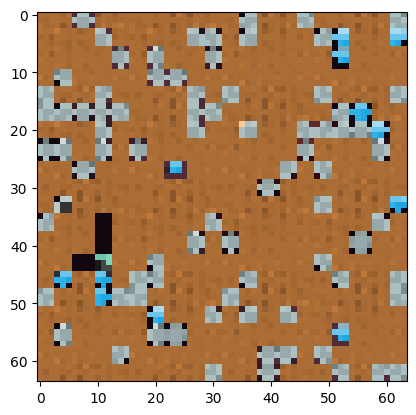

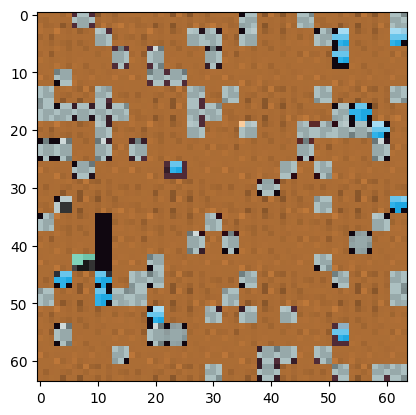

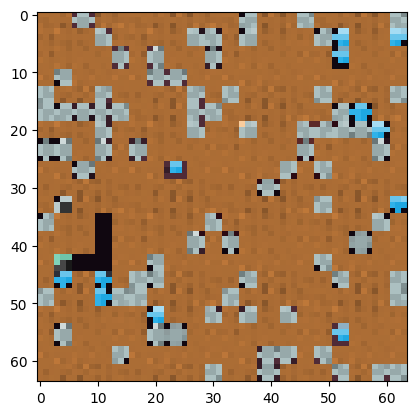

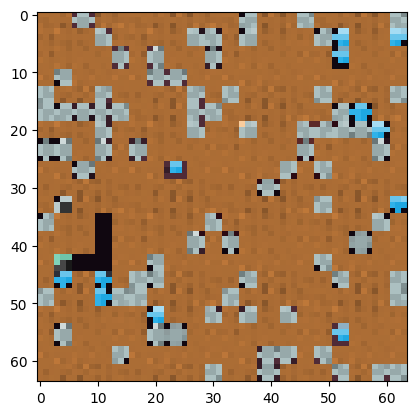

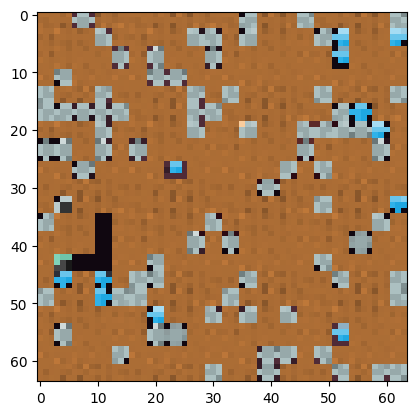

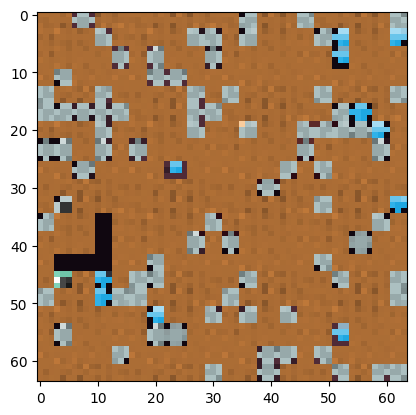

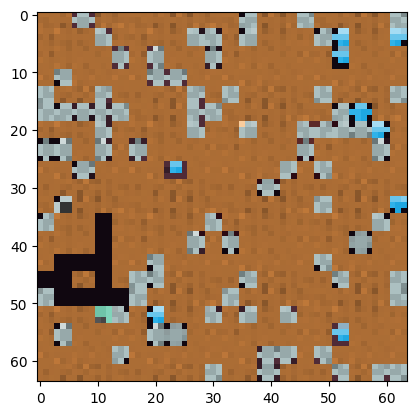

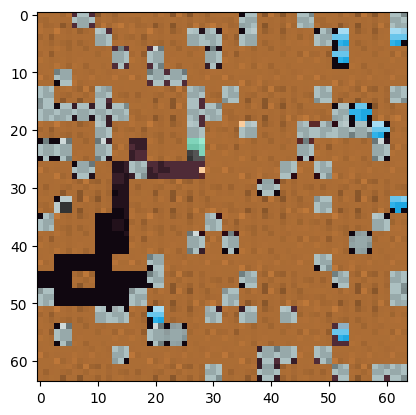

In [181]:
e = make_single_env()
obs, _ = e.reset()
for i, action in enumerate(env.envs[0].past_actions[-1]):
    obs, _, _, _, _ = e.step(action)
    if i<10 or i%50==0:
        plt.imshow(obs[-1])
        plt.show()

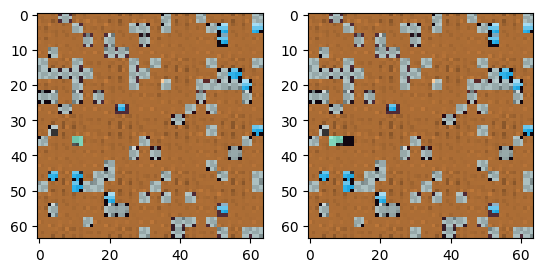

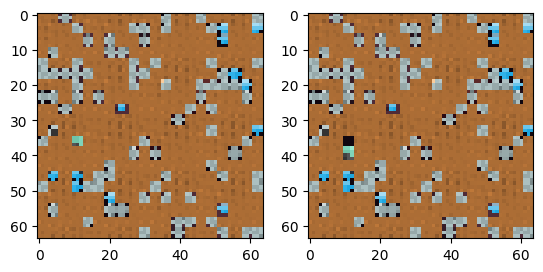

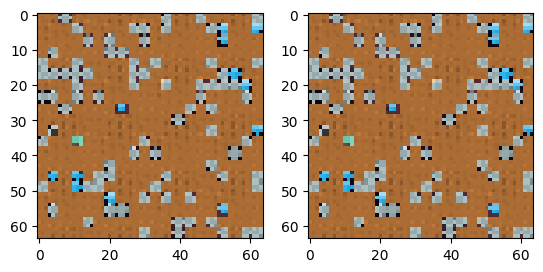

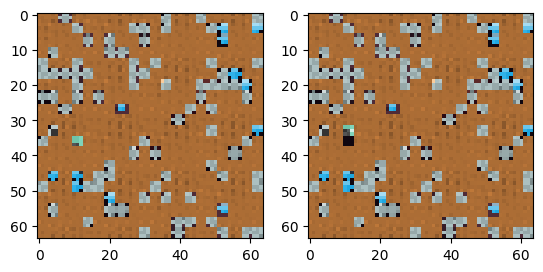

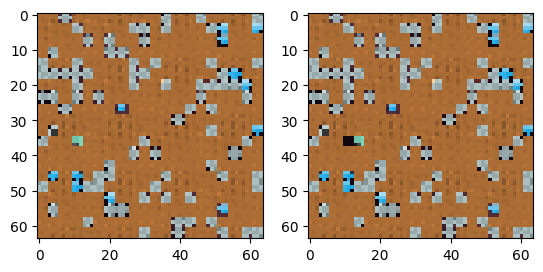

In [53]:

env = make_env(1)
obs, info = env.reset()
for action in range(env.single_action_space.n):
    env = make_env(1)
    obs, info = env.reset()
    plt.subplot(121)
    plt.imshow(obs[0, -1])
    obs, _, _, _, _ = env.step([action])
    plt.subplot(122)
    plt.imshow(obs[0, -1])
    plt.show()
    